In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [2]:
import numpy as np
import matplotlib.lines as mlines

P = 19
A = -3
B = 5

# Following two functions for inverting number on field of integers modulo p are from
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
def extended_euclidean_algorithm(a, b):
    """
    Returns a three-tuple (gcd, x, y) such that
    a * x + b * y == gcd, where gcd is the greatest
    common divisor of a and b.

    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case.
    """
    s, old_s = 0, 1
    t, old_t = 1, 0
    r, old_r = b, a

    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t

    return old_r, old_s, old_t


def inverse_of(n, p):
    """
    Returns the multiplicative inverse of
    n modulo p.

    This function returns an integer m such that
    (n * m) % p == 1.
    """
    gcd, x, y = extended_euclidean_algorithm(n, p)
    assert (n * x + p * y) % p == gcd

    if gcd != 1:
        # Either n is 0, or p is not a prime number.
        raise ValueError(
            '{} has no multiplicative inverse '
            'modulo {}'.format(n, p))
    else:
        return x % p

    
class Point:
    def __init__(self, p, x=float('inf'), y=float('inf')):
        self.p = p
        self.x = x % p
        self.y = y % p
        
    def __repr__(self):
        return "Point(p={}, x={}, y={})".format(self.p, self.x, self.y)
    
    def __add__(self, other):
        assert type(other) is Point
        if self.x == other.x and self.y == other.y:
            return self.double()
        dx = other.x - self.x
        dy = other.y - self.y
        if dx == 0:
            return Point()
        slope = dy * inverse_of(dx, self.p)
        x = (slope ** 2) - self.x - other.x
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def double(self):
        slope = (3 * (self.x ** 2) + A) * inverse_of(2 * self.y, self.p)
        x = (slope ** 2) - (2 * self.x)
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def oppsite(self):
        return Point(self.p, self.x, -self.y)
    
    def np(self):
        return np.array([self.x, self.y])
    

In [3]:
import matplotlib.pyplot as plt

def enumerate_points(p):
    # TODO: this is silly way, maybe there's a better way
    for x in range(p):
        for y in range(p):
            if (y ** 2) % p == ((x ** 3) + A * x + B) % p:
                yield (x, y)

                
def plot_curve(p, a, b, ax):
    points = list(enumerate_points(p))
    points = np.array(points)
    # print(points)

    ax.scatter(points[:,0], points[:,1], zorder=5)
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.set_ylim(top=p)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlim(right=p)

In [100]:
import math
from matplotlib.ticker import MaxNLocator

def plot_distinct_point_curve(p0, p1, p0_annotation, p1_annotation, third_point_annotation, sum_point_annotation):
    p2 = p0 + p1

    fig, ax = plt.subplots()

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plot_curve(P, A, B, ax)

    dx = p1.x - p0.x
    dy = p1.y - p0.y
    
    dx_dy_gcd = math.gcd(dx, dy)
    print("!!", dx_dy_gcd)
    dx = int(dx / dx_dy_gcd)
    dy = int(dy / dx_dy_gcd)
    
    cx = p0.x
    cy = p0.y
    
    print("p0", p0)
    print("p1", p1)
    print("dx", dx)
    print("dy", dy)
    p2_flip = -p2.y % P
    
    idx = 0
    while cx != p2.x or cy != p2_flip:
        newx = cx
        newy = cy
        newx += dx
        newy += dy
        print("draw", cx, cy, newx, newy, ['r', 'g', 'b'][idx % 3])
        ax.add_line(mlines.Line2D([cx, newx], [cy, newy], color=['r', 'g', 'b'][idx % 3], zorder=1))
        newx %= P
        newy %= P
        # If the line cross edge, let's draw the second part from the pointer 
        if newx < cx or newy < cy:
            ax.add_line(mlines.Line2D([newx - dx, newx], [newy - dy, newy], color=['r', 'g', 'b'][idx % 3], zorder=1))
        print(newx, newy)
        cx = newx
        cy = newy
        idx += 1
        if idx >= 15:
            break

    ax.annotate(p0_annotation, xy=p0.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(p1_annotation, xy=p1.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(sum_point_annotation, xy=p2.np(), xytext=(-5, 5), textcoords='offset points')
    
    plt.show()

!! 2
p0 Point(p=19, x=3, y=2)
p1 Point(p=19, x=5, y=18)
dx 1
dy 8
draw 3 2 4 10 r
4 10
draw 4 10 5 18 g
5 18
draw 5 18 6 26 b
!! cross
6 7
draw 6 7 7 15 r
7 15
draw 7 15 8 23 g
!! cross
8 4
draw 8 4 9 12 b
9 12
draw 9 12 10 20 r
!! cross
10 1
draw 10 1 11 9 g
11 9
draw 11 9 12 17 b
12 17
draw 12 17 13 25 r
!! cross
13 6
draw 13 6 14 14 g
14 14
draw 14 14 15 22 b
!! cross
15 3
draw 15 3 16 11 r
16 11
draw 16 11 17 19 g
!! cross
17 0
draw 17 0 18 8 b
18 8


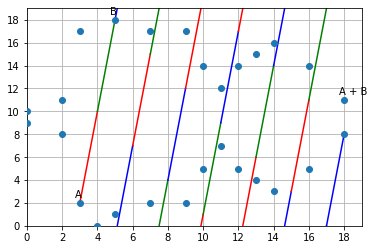

Point(p=19, x=18, y=11)

In [101]:
a = Point(P, 3, 2)
b = Point(P, 5, 18)
c = Point(P, 10, 14)
plot_distinct_point_curve(
    a, b,
    'A', 'B', '', 'A + B'
)
a + b

!! 1
p0 Point(p=19, x=5, y=18)
p1 Point(p=19, x=10, y=14)
dx 5
dy -4
draw 5 18 10 14 r
!! cross
10 14
draw 10 14 15 10 g
!! cross
15 10
draw 15 10 20 6 b
!! cross
1 6
draw 1 6 6 2 r
!! cross
6 2
draw 6 2 11 -2 g
11 17
draw 11 17 16 13 b
!! cross
16 13
draw 16 13 21 9 r
!! cross
2 9
draw 2 9 7 5 g
!! cross
7 5
draw 7 5 12 1 b
!! cross
12 1
draw 12 1 17 -3 r
17 16
draw 17 16 22 12 g
!! cross
3 12
draw 3 12 8 8 b
!! cross
8 8
draw 8 8 13 4 r
!! cross
13 4


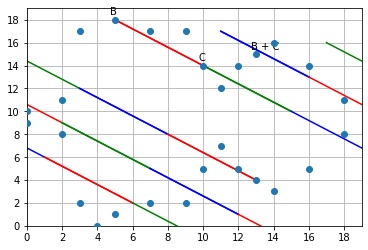

Point(p=19, x=13, y=15)

In [102]:
plot_distinct_point_curve(
    b, c,
    'B', 'C', '', 'B + C'
)
b + c

In [103]:
(a + b) + c, a + (b + c)

(Point(p=19, x=14, y=16), Point(p=19, x=14, y=16))

In [104]:
p0x = 5
p0y = 18
dx = 5
dy = -4
for _ in range(60):
    p0x += dx
    p0y += dy
    p0x %= P
    p0y %= P
    print(p0x, p0y)

10 14
15 10
1 6
6 2
11 17
16 13
2 9
7 5
12 1
17 16
3 12
8 8
13 4
18 0
4 15
9 11
14 7
0 3
5 18
10 14
15 10
1 6
6 2
11 17
16 13
2 9
7 5
12 1
17 16
3 12
8 8
13 4
18 0
4 15
9 11
14 7
0 3
5 18
10 14
15 10
1 6
6 2
11 17
16 13
2 9
7 5
12 1
17 16
3 12
8 8
13 4
18 0
4 15
9 11
14 7
0 3
5 18
10 14
15 10
1 6


In [105]:
p0x = 3
p0y = 2
dx = 1
dy = 8
for _ in range(60):
    p0x += dx
    p0y += dy
    p0x %= P
    p0y %= P
    print(p0x, p0y)

4 10
5 18
6 7
7 15
8 4
9 12
10 1
11 9
12 17
13 6
14 14
15 3
16 11
17 0
18 8
0 16
1 5
2 13
3 2
4 10
5 18
6 7
7 15
8 4
9 12
10 1
11 9
12 17
13 6
14 14
15 3
16 11
17 0
18 8
0 16
1 5
2 13
3 2
4 10
5 18
6 7
7 15
8 4
9 12
10 1
11 9
12 17
13 6
14 14
15 3
16 11
17 0
18 8
0 16
1 5
2 13
3 2
4 10
5 18
6 7
